In [28]:
import torch

import triton
import triton.language as tl


def is_cuda():
    return False


def is_hip_mi200():
    return True

def get_cuda_autotune_config():
    return [
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3,
                      num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5,
                      num_warps=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5,
                      num_warps=2),
        # Good config for fp8 inputs.
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=3,
                      num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=3,
                      num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4)
    ]


def get_hip_autotune_config():
    return [
        triton.Config(
            {'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 16, 'GROUP_SIZE_M': 1, 'waves_per_eu': 2},
            num_warps=4, num_stages=0),
        triton.Config(
            {'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 16, 'GROUP_SIZE_M': 4, 'waves_per_eu': 2},
            num_warps=8, num_stages=0),
        triton.Config(
            {'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 1, 'waves_per_eu': 2},
            num_warps=8, num_stages=0),
        triton.Config(
            {'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8, 'waves_per_eu': 3},
            num_warps=4, num_stages=0),
        triton.Config(
            {'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 1, 'waves_per_eu': 8},
            num_warps=4, num_stages=0),
    ]


def get_autotune_config():
    if is_cuda():
        return get_cuda_autotune_config()
    else:
        return get_hip_autotune_config()


# `triton.jit`'ed functions can be auto-tuned by using the `triton.autotune` decorator, which consumes:
#   - A list of `triton.Config` objects that define different configurations of
#       meta-parameters (e.g., `BLOCK_SIZE_M`) and compilation options (e.g., `num_warps`) to try
#   - An auto-tuning *key* whose change in values will trigger evaluation of all the
#       provided configs
@triton.autotune(
    configs=get_autotune_config(),
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel(
        # Pointers to matrices
        a_ptr, b_ptr, c_ptr,
        # Matrix dimensions
        M, N, K,
        # The stride variables represent how much to increase the ptr by when moving by 1
        # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
        # by to get the element one row down (A has M rows).
        stride_am, stride_ak,  #
        stride_bk, stride_bn,  #
        stride_cm, stride_cn,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        GROUP_SIZE_M: tl.constexpr,  #
        ACTIVATION: tl.constexpr  #
):
    """Kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    # This is done in a grouped ordering to promote L2 data reuse.
    # See above `L2 Cache Optimizations` section for details.
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    # ----------------------------------------------------------
    # Create pointers for the first blocks of A and B.
    # We will advance this pointer as we move in the K direction
    # and accumulate
    # `a_ptrs` is a block of [BLOCK_SIZE_M, BLOCK_SIZE_K] pointers
    # `b_ptrs` is a block of [BLOCK_SIZE_K, BLOCK_SIZE_N] pointers
    # See above `Pointer Arithmetic` section for details
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop.
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)
        # We accumulate along the K dimension.
        accumulator += tl.dot(a, b)
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk
    # You can fuse arbitrary activation functions here
    # while the accumulator is still in FP32!
    if ACTIVATION == "leaky_relu":
        accumulator = leaky_relu(accumulator)
    c = accumulator.to(tl.float16)

    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)


# We can fuse `leaky_relu` by providing it as an `ACTIVATION` meta-parameter in `matmul_kernel`.
@triton.jit
def leaky_relu(x):
    return tl.where(x >= 0, x, 0.01 * x)

In [29]:
def matmul(a, b, activation=""):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"
    M, K = a.shape
    K, N = b.shape
    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    matmul_kernel[grid](
        a, b, c,  #
        M, N, K,  #
        a.stride(0), a.stride(1),  #
        b.stride(0), b.stride(1),  #
        c.stride(0), c.stride(1),  #
        ACTIVATION=activation  #
    )
    return c

In [30]:
torch.manual_seed(0)
a = torch.randn((512, 512), device='cuda', dtype=torch.float16)
b = torch.randn((512, 512), device='cuda', dtype=torch.float16)
triton_output = matmul(a, b)
torch_output = torch.matmul(a, b)
print(f"triton_output_with_fp16_inputs={triton_output}")
print(f"torch_output_with_fp16_inputs={torch_output}")
# Bigger tolerance for AMD MI200 devices.
# MI200 devices use reduced precision fp16 and bf16 and flush input and
# output denormal values to zero. Detailed info is at: https://pytorch.org/docs/stable/notes/numerical_accuracy.html#reduced-precision-fp16-and-bf16-gemms-and-convolutions-on-amd-instinct-mi200-devices
rtol = 1e-2 if is_hip_mi200() else 0
if torch.allclose(triton_output, torch_output, atol=1e-2, rtol=rtol):
    print("✅ Triton and Torch match")
else:
    print("❌ Triton and Torch differ")

TORCH_HAS_FP8 = hasattr(torch, "float8_e5m2")
if TORCH_HAS_FP8 and is_cuda():
    torch.manual_seed(0)
    a = torch.randn((512, 512), device="cuda", dtype=torch.float16)
    b = torch.randn((512, 512), device="cuda", dtype=torch.float16)
    a = a.to(torch.float8_e5m2)
    # pre-transpose b for efficiency.
    b = b.T
    b = b.to(torch.float8_e5m2)
    triton_output = matmul(a, b)
    torch_output = torch.matmul(a.to(torch.float16), b.to(torch.float16))
    print(f"triton_output_with_fp8_inputs={triton_output}")
    print(f"torch_output_with_fp8_inputs={torch_output}")
    if torch.allclose(triton_output, torch_output, atol=0.125, rtol=0):
        print("✅ Triton and Torch match")
    else:
        print("❌ Triton and Torch differ")

triton_output_with_fp16_inputs=tensor([[ -8.8203, -12.6719,  -8.2656,  ..., -13.4531,   6.2500, -40.4375],
        [ 33.8125,  12.3672,   0.7725,  ...,  -1.1689,   0.4497,  31.0469],
        [ -6.5039,   8.5938,  11.1953,  ..., -14.5312, -35.5312,  -2.8164],
        ...,
        [-23.3125,  -4.1875,  39.2188,  ..., -30.9375,  28.0000,  22.2031],
        [-18.4375,  12.9531,   5.8711,  ..., -14.1328, -31.1719,   7.1406],
        [  6.7578, -38.4688,  -6.5938,  ...,  32.0938, -21.2188, -57.2812]],
       device='cuda:0', dtype=torch.float16)
torch_output_with_fp16_inputs=tensor([[ -8.8203, -12.6719,  -8.2656,  ..., -13.4531,   6.2500, -40.4375],
        [ 33.8125,  12.3672,   0.7725,  ...,  -1.1689,   0.4497,  31.0469],
        [ -6.5039,   8.5938,  11.1953,  ..., -14.5312, -35.5312,  -2.8164],
        ...,
        [-23.3125,  -4.1875,  39.2188,  ..., -30.9375,  28.0000,  22.2031],
        [-18.4375,  12.9531,   5.8711,  ..., -14.1328, -31.1719,   7.1406],
        [  6.7578, -38.4688,  -

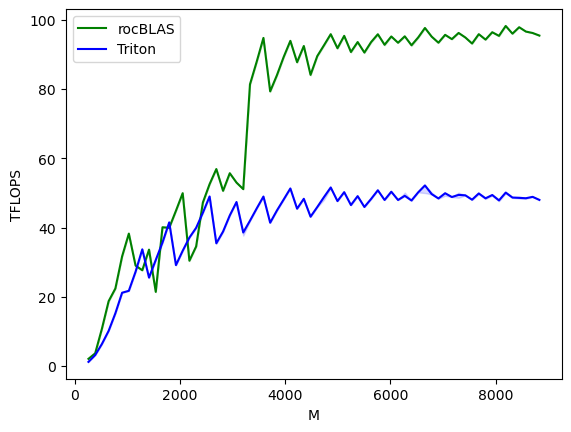

matmul-performance-fp16:
         M       N       K    rocBLAS     Triton
0    256.0   256.0   256.0   2.056031   1.178175
1    384.0   384.0   384.0   3.648396   3.145728
2    512.0   512.0   512.0  10.754626   6.355006
3    640.0   640.0   640.0  18.724571  10.144892
4    768.0   768.0   768.0  22.380674  15.221265
..     ...     ...     ...        ...        ...
63  8320.0  8320.0  8320.0  96.019460  48.663494
64  8448.0  8448.0  8448.0  97.876143  48.566724
65  8576.0  8576.0  8576.0  96.621279  48.461487
66  8704.0  8704.0  8704.0  96.210241  48.862238
67  8832.0  8832.0  8832.0  95.468482  47.987733

[68 rows x 5 columns]


In [31]:
ref_lib = 'cuBLAS' if is_cuda() else 'rocBLAS'

configs = []
for fp8_inputs in [False, True]:
    if fp8_inputs and (not TORCH_HAS_FP8 or not is_cuda()):
        continue
    configs.append(
        triton.testing.Benchmark(
            x_names=["M", "N", "K"],  # Argument names to use as an x-axis for the plot
            x_vals=[128 * i for i in range(2, 70)],  # Different possible values for `x_name`
            line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
            # Possible values for `line_arg`
            # Don't compare to cublas for fp8 cases as torch.matmul doesn't support fp8 at the moment.
            line_vals=["triton"] if fp8_inputs else [ref_lib.lower(), "triton"],  # Label name for the lines
            line_names=["Triton"] if fp8_inputs else [ref_lib, "Triton"],  # Line styles
            styles=[("green", "-"), ("blue", "-")],
            ylabel="TFLOPS",  # Label name for the y-axis
            plot_name="matmul-performance-" +
            ("fp16" if not fp8_inputs else "fp8"),  # Name for the plot, used also as a file name for saving the plot.
            args={"fp8_inputs": fp8_inputs},
        ))


@triton.testing.perf_report(configs)
def benchmark(M, N, K, provider, fp8_inputs):
    a = torch.randn((M, K), device='cuda', dtype=torch.float16)
    b = torch.randn((K, N), device='cuda', dtype=torch.float16)
    if TORCH_HAS_FP8 and fp8_inputs:
        a = a.to(torch.float8_e5m2)
        b = b.T
        b = b.to(torch.float8_e5m2)
    quantiles = [0.5, 0.2, 0.8]
    if provider == ref_lib.lower():
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(a, b), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul(a, b), quantiles=quantiles)
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


benchmark.run(show_plots=True, print_data=True)

# Get timings instead of TFLOPS

In [18]:
import time
from math import ceil
from statistics import median

xs = []
triton_times = []
torch_times = []
works = []

for i in range(64, 10000, 64):
    xs.append(i)
    
    M = i
    N = i
    K = i
    
    a = torch.randn((M, K), device="cuda", dtype=torch.float16)
    b = torch.randn((K, N), device="cuda", dtype=torch.float16)

    cache_size = 256 * 1024 * 1024
    cache = torch.empty(int(cache_size), dtype=torch.int8, device='cuda')
    
    # warmup time for autotuner
    for i in range(5):
        c = matmul(a, b)
        del c

    thisrun_triton = []

    for i in range(10):
        torch.cuda.synchronize()
        cache.zero_()
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        c = matmul(a, b)
        end_event.record()
        torch.cuda.synchronize()
        thisrun_triton.append(start_event.elapsed_time(end_event))

    triton_times.append(median(thisrun_triton))

    for i in range(5):
        torch_result = torch.matmul(a, b)
        del torch_result

    thisrun_torch = []

    for i in range(10):
        torch.cuda.synchronize()
        cache.zero_()
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        torch_result = torch.matmul(a, b)
        end_event.record()
        torch.cuda.synchronize()
        #print(torch_result[indices[0]][indices[1]])
        #elapsed = time.time() - start_time
        thisrun_torch.append(start_event.elapsed_time(end_event))
    

    torch_times.append(median(thisrun_torch))

    max_diff = torch.max(torch_result - c)
    print(max_diff, '< 1e-2 ?', max_diff < 1e-2)

    works.append(max_diff.item())

    del a
    del b
    del c
    del torch_result

tensor(1.5259e-05, device='cuda:0', dtype=torch.float16) < 1e-2 ? tensor(True, device='cuda:0')
tensor(0.0039, device='cuda:0', dtype=torch.float16) < 1e-2 ? tensor(True, device='cuda:0')
tensor(0.0078, device='cuda:0', dtype=torch.float16) < 1e-2 ? tensor(True, device='cuda:0')
tensor(0.0156, device='cuda:0', dtype=torch.float16) < 1e-2 ? tensor(False, device='cuda:0')
tensor(0.0078, device='cuda:0', dtype=torch.float16) < 1e-2 ? tensor(True, device='cuda:0')
tensor(0.0156, device='cuda:0', dtype=torch.float16) < 1e-2 ? tensor(False, device='cuda:0')
tensor(0.0312, device='cuda:0', dtype=torch.float16) < 1e-2 ? tensor(False, device='cuda:0')
tensor(0.0312, device='cuda:0', dtype=torch.float16) < 1e-2 ? tensor(False, device='cuda:0')
tensor(0.0312, device='cuda:0', dtype=torch.float16) < 1e-2 ? tensor(False, device='cuda:0')
tensor(0.0625, device='cuda:0', dtype=torch.float16) < 1e-2 ? tensor(False, device='cuda:0')
tensor(0.0312, device='cuda:0', dtype=torch.float16) < 1e-2 ? tensor(F

In [19]:
import matplotlib.pyplot as plt

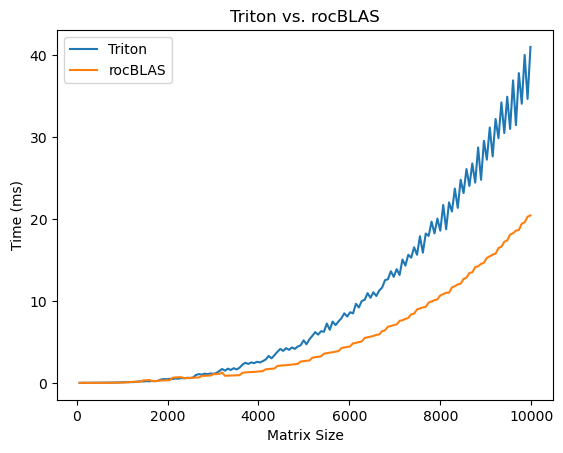

In [22]:
# Plotting both the curves simultaneously
plt.plot(xs, triton_times, label='Triton')  # Plotting the first line
plt.plot(xs, torch_times, label='rocBLAS')  # Plotting the second line

# Naming the x-axis, y-axis and the whole graph
plt.xlabel('Matrix Size')
plt.ylabel('Time (ms)')
plt.title('Triton vs. rocBLAS')

# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()